<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraries and Utilities</h3>


In [40]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import networkx          as nx
import seaborn           as sns
from nltk                import ngrams
from pyvis.network       import Network
import os
import re
import nltk
import pydot
import spacy as sp
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import STOPWORDS
from string import punctuation
import enchant
import pickle
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
wchecker = enchant.Dict("en_US")
nlps = sp.load('en_core_web_sm')

In [2]:
class BiGramGraph:
    """
    A class used to transform a corpus given as a numpy array into a graph form of the
    2-gram representation.

    ...

    Attributes
    ----------
    Graph : nx.Graph
        The Graph Representation of The Ngram Input.
    N_nodes : int
        Number of Nodes in Graph.
    N_edges : int
        Number of Edges in Graph.
    In_Max_Deg : int
        Maximum In Degree in Graph.
    Out_Max_Deg : int
        Maximum Out Degree in Graph.
    In_Min_Deg : int
        Minimum In Degree in Graph.
    Out_Min_Deg : int
        Minimum Out Degree in Graph.

    Methods
    -------
    Example_Method(arg=None)
        Add info
    """

    def __init__(self, data=None,prebuild=None, notebook=False):
        if prebuild != None:
                self.Graph        = prebuild[0]
                self.N_nodes      = prebuild[1]
                self.N_edges      = prebuild[2]
                self.In_Max_Deg   = prebuild[3]
                self.Out_Max_Deg  = prebuild[4]
                self.In_Min_Deg   = prebuild[5]
                self.Out_Min_Deg  = prebuild[6]
                self.Data         = prebuild[7]
                self.Name         = prebuild[8]
                self.Edge         = prebuild[9]
        else:
            if not notebook:
                from tqdm import tqdm
                tqdm.pandas()
            else:
                from tqdm.notebook import tqdm
                tqdm.pandas()

            n = 2
            tokenized_text = ' '.join(data).split()
            ngram = ngrams(tokenized_text, n=n)
            ngram = list(ngram)

            n_frequencies = nltk.FreqDist(ngram)
            edges = list(dict(n_frequencies).keys())
            nodes = np.unique(np.array(edges).flatten())
            self.Graph = nx.DiGraph()
            self.Graph.add_nodes_from(nodes)
            for x, y in edges:
                self.Graph.add_edge(x, y, value=n_frequencies[(x, y)])

                # Graph Attributes
            self.N_nodes = len(nodes)
            self.N_edges = len(edges)
            self.In_Max_Deg = max(dict(self.Graph.in_degree).values())
            self.Out_Max_Deg = max(dict(self.Graph.out_degree).values())
            self.In_Min_Deg = min(dict(self.Graph.in_degree).values())
            self.Out_Min_Deg = min(dict(self.Graph.out_degree).values())
            self._nlp = None
            self.Data = nx.algorithms.coloring.greedy_color(self.Graph)
            self.Data = pd.DataFrame([self.Data.values(),
                                      self.Data.keys()]).T.rename(columns={0: 'color', 1: 'word'})
            self.Name='Default Name'

            self.Edges = pd.DataFrame(edges, columns=['in', 'out'])
            self.Edges['weight'] = self.Edges.apply(lambda _z: n_frequencies[(_z['in'], _z['out'])], axis=1)

    def add_part_of_speech(self):
        import spacy as sp
        self._nlp = sp.load('en_core_web_sm')
        self.Data['pos'] = self.Data['word'].progress_apply(lambda _z: self._nlp(str(_z))[0].pos_)

    def get_Xi(self) -> int:
        """
        :return: The chromatic number of the graph.
        """
        return self.Data['color'].max() + 1
    
    def is_DAG(self):
        return nx.algorithms.dag.is_directed_acyclic_graph(self.Graph)
    def get_Diameter(self):
        return nx.algorithms.distance_measures.diameter(self.Graph)
    
    def get_Min_Edge_Cover(self):
        return nx.algorithms.covering.min_edge_cover(self.Graph)
    
    def get_Shortest_Simple_Path(self,start_node,end_node):
        return nx.algorithms.simple_paths.shortest_simple_paths(self.Graph,source=start_node,target=end_node)
    
    def get_Eulerian(self):
        if nx.is_eulerian(self.Graph):
            return nx.eulerian_circuit()(self.Graph)
        else:
            return 'Not Eulerian'
        
    def get_Volume(self,S):
        return nx.algorithms.cuts.volume(self.Graph,S)
        
    def get_Eulerian_Path(self):
        return nx.eulerian_path(self.Graph) if nx.has_eulerian_path(self.Graph) else "Graph Has No Eulerian Path"
        
    def get_Cycle(self,start_node):
        return nx.algorithms.cycles.find_cycle(self.Graph,start_node)
    
    def get_All_Unique_Cycles(self):
        hash_list = []
        unique_cycle = []
        for i in tqdm(range(11857)):
            cyclye = self.get_Cycle(Bigraph.Data.word[i])
            c_hash = hash(str(self.get_Cycle(self.Data.word[i])))
            if c_hash not in hash_list:
                hash_list.append(c_hash)
                unique_cycle.append(cyclye)
        return unique_cycle
    def get_All_Simple_Cycles(self):
        return nx.algorithms.cycles.simple_cycles(self.Graph)
    
    def is_Strongly_Connected(self):
        return nx.algorithms.components.is_strongly_connected(self.Graph)
    def get_Number_Strongly_Connected_Components(self):
        return nx.algorithms.components.number_strongly_connected_components(self.Graph)
    def get_Strongly_Connected_Components(self):
        return nx.algorithms.components.strongly_connected_components(self.Graph)
            

    def __repr__(self):
        n = self.N_nodes
        e = self.N_edges
        xi = self.get_Xi()
        return f'Number of words included: {n}\nNumber of edges included: {e}\nChromatic number: {xi}\n'

    def __getitem__(self, item) -> dict:
        return dict()

    def vectorize(self, string, method='chromatic'):
        if method == 'chromatic':
            tokens = string.split(' ')
            vec_form = []
            for tok in tokens:
                if tok not in self.Data.word.values:
                    continue
                vec_form.append(self.Data.query(f'word == "{tok}"')['color'].values[0])
            return vec_form
        else:
            raise NameError('Bad Method')
            
    def dump(self):
        return [self.Graph,
                self.N_nodes,
                self.N_edges,
                self.In_Max_Deg,
                self.Out_Max_Deg,
                self.In_Min_Deg,
                self.Out_Min_Deg,
                self.Data,
                self.Name,
                self.Edges
               ]


    def Viz_Graph(self, notebook=False, height=500, width=900, directed=False):
        nt = Network(f'{height}px', f'{width}px', notebook=notebook, directed=directed)
        nt.set_options(
            'var options = { "physics": {"forceAtlas2Based": {"gravitationalConstant": -230,"springLength": 170,\
              "springConstant": 0,\
              "avoidOverlap": 1\
            },\
            "minVelocity": 0.75,\
            "solver": "forceAtlas2Based",\
            "timestep": 1\
          }\
        }\
        ')
        nt.from_nx(self.Graph)
        # nt.show_buttons(filter_=['physics'])
        nt.prep_notebook()
        return nt.show('nx.html')


In [3]:
#Utils

def calculate_path_weight(Graph,path):
    weight = 0
    start = path[0]
    for i in path[1:]:
        weight += Graph.Edges[(Graph.Edges['in'] == start[0])&(Graph.Edges.out == i[0])].weight.values[0]
        start =i
    return weight

def calculate_cycle_density(Graph,cycle):
    weight = 0
    for i in cycle:
        weight += np.sqrt(Graph.Graph.out_degree(i[0])+Graph.Graph.in_degree(i[0]))
    return weight    

def calculate_path_density(Graph,path):
    weight = 0
    for i in path:
        IN  = Graph.Graph.out_degree(i[0])
        OUT = Graph.Graph.in_degree(i[0])
        if type(IN)!=int:
            weight += np.sqrt(OUT)
        elif type(OUT) != int:
            weight += np.sqrt(IN)
        else:
            weight+= np.sqrt(IN+OUT)
    return weight 
    

<h3 style="background-color:skyblue;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Graph Attribute Exploration</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Chromatic Number</h3>


 
<h3 style="background-color:green;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Texts Dataset</h3>


In [4]:
def remove_punct(text):
    table=str.maketrans('','',punctuation)
    return text.translate(table)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def word_validation(text):
    words = text.split(' ')
    words = [i for i in words if wchecker.check(i) == True]
    return ' '.join(words)


In [100]:
multi_text = pd.read_parquet('/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_text_ds_no_stopwords.parquet')

In [123]:
# bigram_models = []

# for column in tqdm(multi_text.columns):
#     data = multi_text[column][multi_text[column].notna()]
#     G = BiGramGraph(data=data,notebook=True)
#     G.Name=column
#     G.add_part_of_speech()
#     bigram_models.append(G)

In [124]:
# #Save Models
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_text_model_list.pkl", "wb") as file:
#     pickle.dump([i.dump() for i in bigram_models],file)

In [125]:
# Load Pre Fitted Models
with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_text_model_list.pkl", "rb") as file:
    bigraph_models = [BiGramGraph(prebuild=attributes,notebook=True) for attributes in pickle.load(file)]

In [126]:
for idx,graph in enumerate(bigraph_models):
    print(idx+1,') Dataset Name: [',graph.Name,']\n',graph,'\n','--'*20)

1 ) Dataset Name: [ airport_reviews ]
 Number of words included: 9231
Number of edges included: 108142
Chromatic number: 24
 
 ----------------------------------------
2 ) Dataset Name: [ amazon_alexa_reviwes ]
 Number of words included: 3420
Number of edges included: 22249
Chromatic number: 13
 
 ----------------------------------------
3 ) Dataset Name: [ Anime_synopsis ]
 Number of words included: 20835
Number of edges included: 289590
Chromatic number: 24
 
 ----------------------------------------
4 ) Dataset Name: [ bible_text ]
 Number of words included: 11741
Number of edges included: 195863
Chromatic number: 33
 
 ----------------------------------------
5 ) Dataset Name: [ children_books ]
 Number of words included: 1864
Number of edges included: 3249
Chromatic number: 4
 
 ----------------------------------------
6 ) Dataset Name: [ elonmusk_tweets ]
 Number of words included: 4927
Number of edges included: 18175
Chromatic number: 7
 
 ---------------------------------------

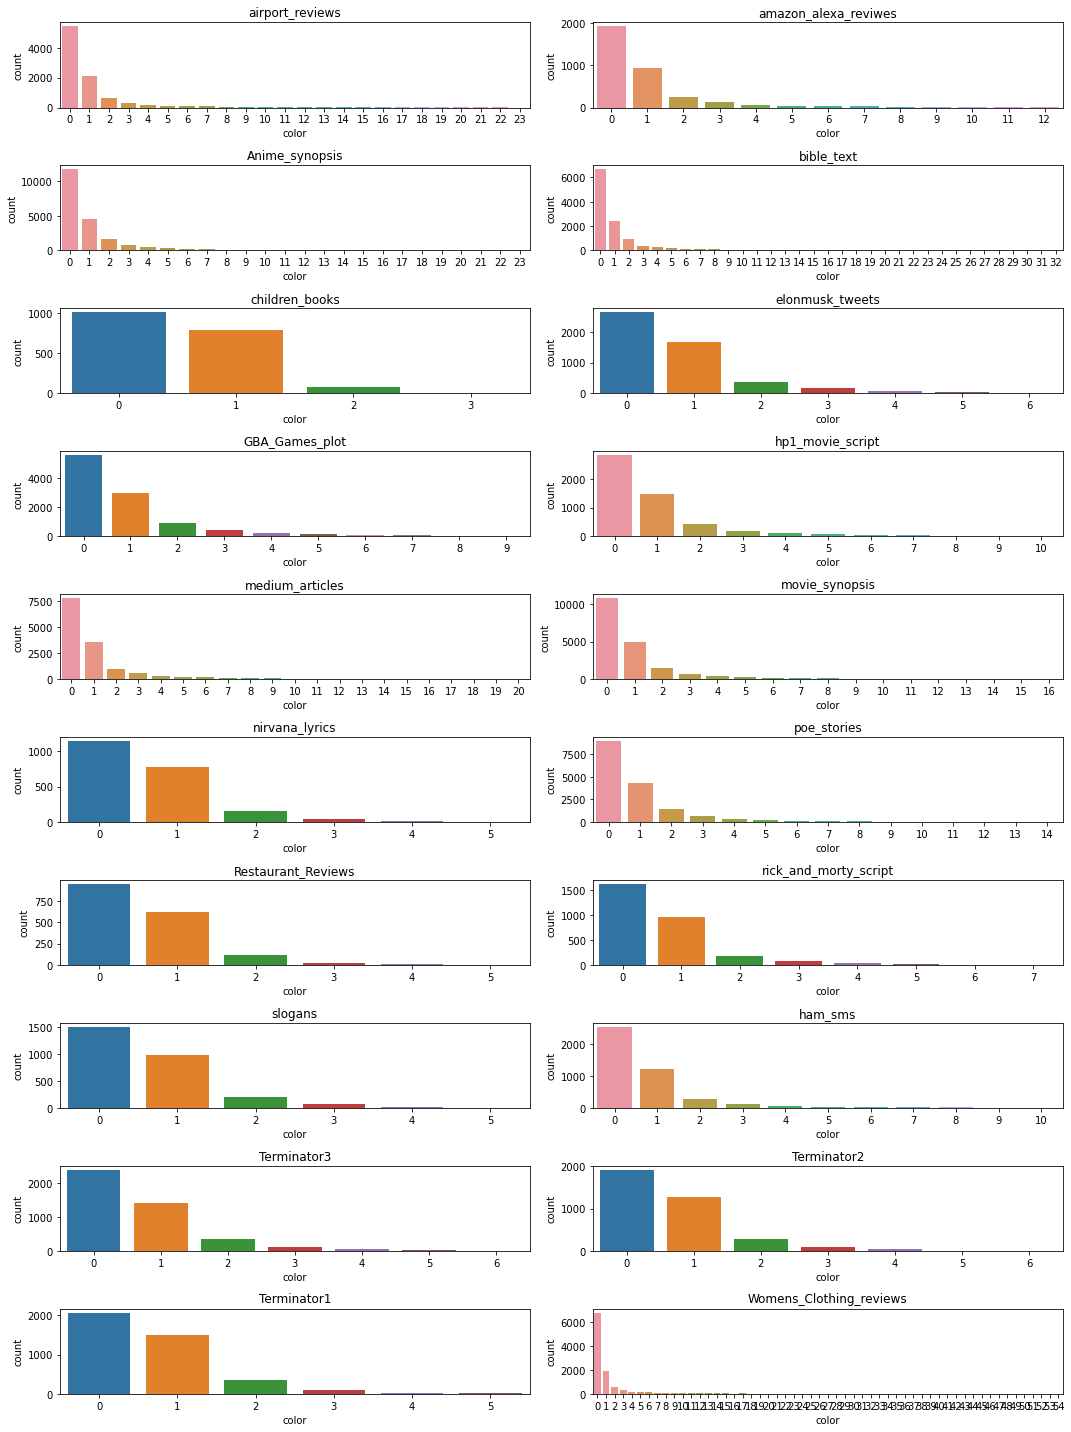

In [127]:
plt.figure(figsize=(15,20))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in enumerate(bigraph_models):
    plt.subplot(10,2,idx+1)
    plt.title(graph.Name)
    sns.countplot(x=graph.Data.color)
plt.tight_layout()
plt.show()

In [128]:
'''
Question 1) Are there any connections between low count colors
Question 2) Low dimnesion representation of chromatic vector
Question 3) Is there any connection between part of speech and chromatic number
Question 4) 
'''

'\nQuestion 1) Are there any connections between low count colors\nQuestion 2) Low dimnesion representation of chromatic vector\nQuestion 3) Is there any connection between part of speech and chromatic number\nQuestion 4) \n'

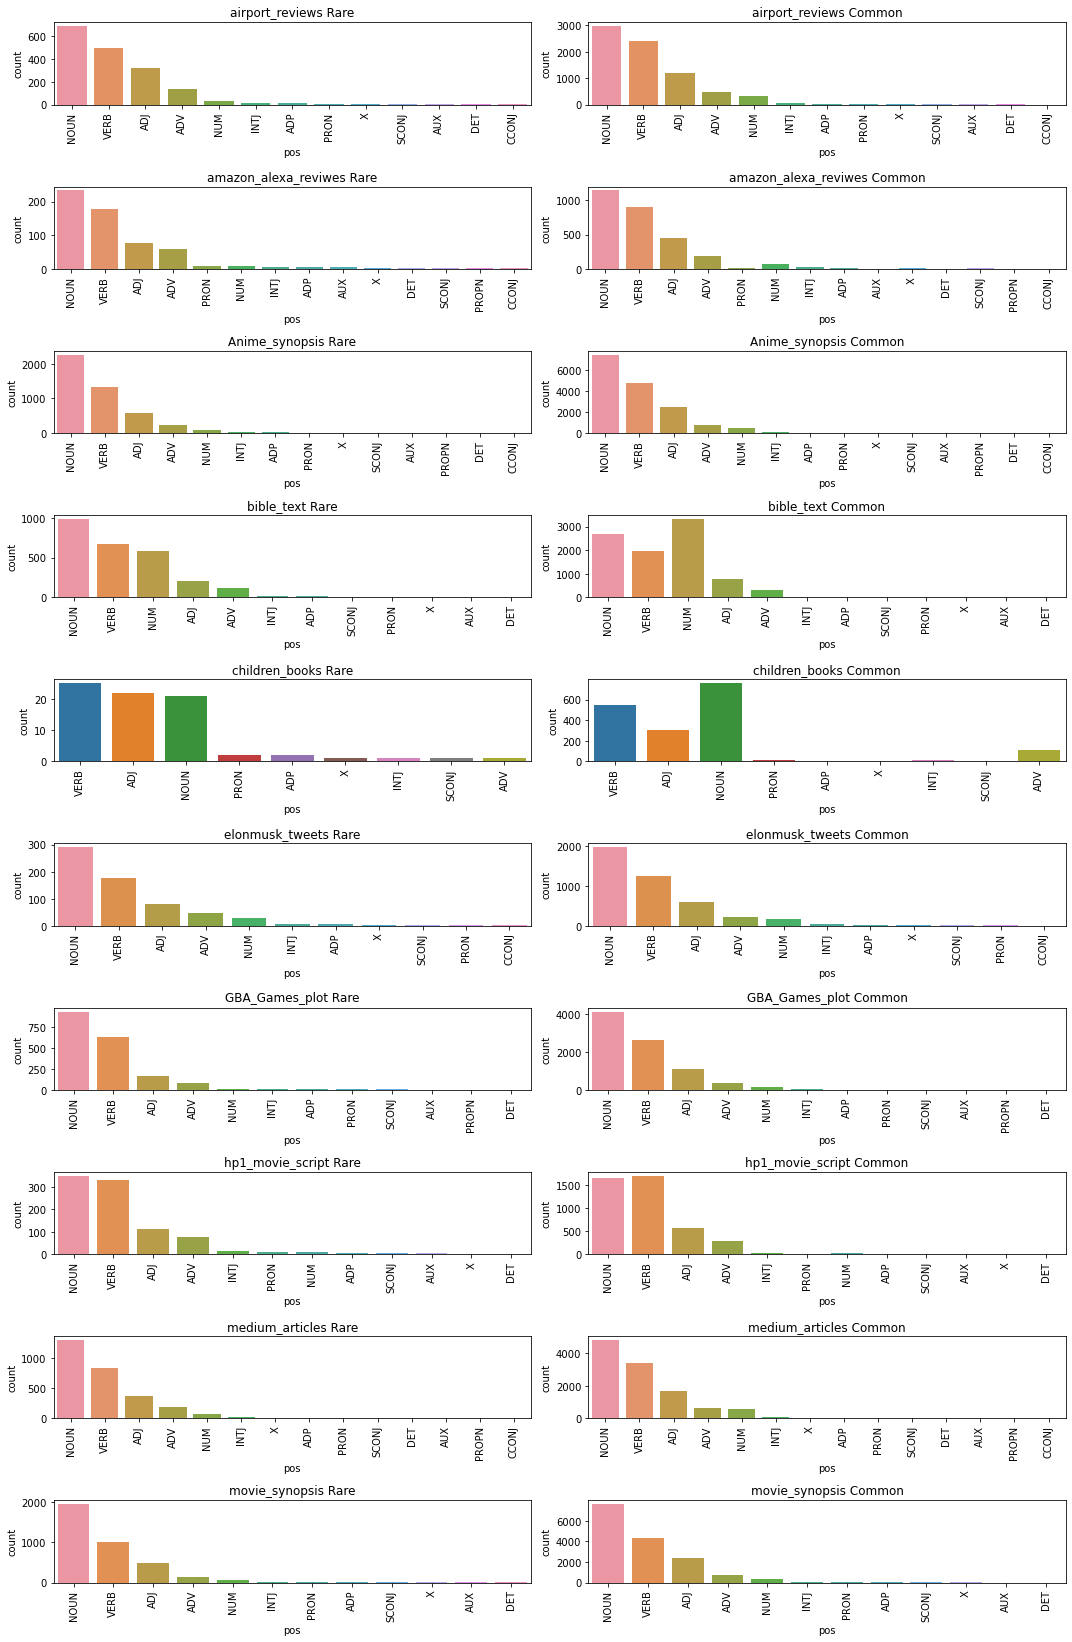

In [129]:

plt.figure(figsize=(15,45))
#plt.subtitle('Distribution of Color Tags')
for idx,graph in zip(range(1,20,2),bigraph_models):
    #calculating rare and common
    threshold = np.round(graph.Data.color.value_counts().max()*0.2)
    color_counts = graph.Data.color.value_counts()
    rare_color_counts = color_counts[color_counts<threshold]
    common_color_counts = color_counts[color_counts>threshold]

    query = ' '.join(f'color == {i} or' for i in rare_color_counts.index)
    query = query[:-3]
    rare_under_testing = graph.Data.query(query)
    rare_under_testing

    query = ' '.join(f'color == {i} or' for i in common_color_counts.index)
    query = query[:-3]
    common_under_testing = graph.Data.query(query)
    common_under_testing

    plt.subplot(20,2,idx)
    plt.title(graph.Name +' Rare')
    ax=sns.countplot(x=rare_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.subplot(20,2,idx+1)
    plt.title(graph.Name+' Common')
    ax=sns.countplot(x=common_under_testing.pos,order=rare_under_testing.pos.value_counts().index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
plt.tight_layout()
plt.show()



In [130]:
# Claculating Text Variance
def text_variabilty(corpus):
    explained_var = 0
    N = 20
    CV=CountVectorizer()
    VECTORIZED = CV.fit_transform(corpus)
    while True:
        L_DIM = TruncatedSVD(N)
        L_DIM.fit(VECTORIZED.todense())
        explained_var = np.sum(L_DIM.explained_variance_ratio_)
        if explained_var >= 0.8:
            break
        else:
            N +=50
    return N,explained_var


In [131]:
variance_dict = dict()
for column in tqdm(multi_text.columns):
    variance_dict[column] = text_variabilty(multi_text[column][multi_text[column].notna()])

  0%|          | 0/20 [00:00<?, ?it/s]

In [135]:
# #Save variance dict
# with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_ds_variance.pkl", "wb") as file:
#     pickle.dump(variance_dict,file)

#load variance dict
with open("/Users/Tomas/Documents/GitHub/NLP-Research-Exploring-Graph-Attributes/Source/Notebooks/multi_ds_variance.pkl", "rb") as file:
    variance_dict = pickle.load(file)

In [137]:
variance_dict

{'airport_reviews': (570, 0.8142720659834938),
 'amazon_alexa_reviwes': (270, 0.8012111418669756),
 'Anime_synopsis': (1520, 0.8006037749365807),
 'bible_text': (1220, 0.8051658761897419),
 'children_books': (70, 1.000000000000013),
 'elonmusk_tweets': (820, 0.8111496968910208),
 'GBA_Games_plot': (120, 0.8401392524381162),
 'hp1_movie_script': (570, 0.8039603176039611),
 'medium_articles': (70, 0.8575481676553128),
 'movie_synopsis': (1920, 0.8003652757969427),
 'nirvana_lyrics': (70, 0.9125791190035515),
 'poe_stories': (70, 0.9999999999999997),
 'Restaurant_Reviews': (320, 0.8187803390937398),
 'rick_and_morty_script': (370, 0.8146211654404436),
 'slogans': (170, 0.8037214393223232),
 'ham_sms': (570, 0.8032334191920281),
 'Terminator3': (970, 0.8115431487677219),
 'Terminator2': (870, 0.8084704718379417),
 'Terminator1': (1070, 0.81319901851725),
 'Womens_Clothing_reviews': (620, 0.812063153216553)}

<AxesSubplot:xlabel='N_Edges', ylabel='ChromN'>

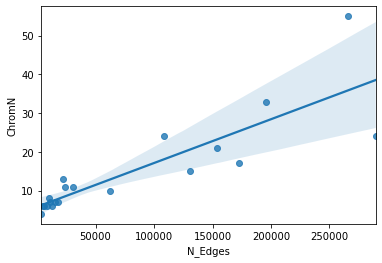

In [156]:
N_for_80_variance = [i[0] for i in list(variance_dict.values())]
chrom_nums = [i.get_Xi() for i in bigraph_models]
indeg_max = [i.In_Max_Deg for i in bigraph_models]
outdeg_max = [i.Out_Max_Deg for i in bigraph_models]
n_nouns =  [i.Data.pos.value_counts().loc['NOUN'] for i in bigraph_models]
n_verbs =  [i.Data.pos.value_counts().loc['VERB'] for i in bigraph_models]
n_nodes =  [i.Data.shape[0] for i in bigraph_models]
n_edges =  [i.N_edges for i in bigraph_models]
#all_unique_cycles =  [len(i.get_All_Unique_Cycles()) for i in bigraph_models]

var_chrom_df = pd.DataFrame({'NComp':N_for_80_variance,'ChromN':chrom_nums,
                            'In_Max_Deg':indeg_max,'Out_Max_Deg':outdeg_max,
                            'N_Nouns':n_nouns,'N_Verbs':n_verbs,'N_Words':n_nodes,'N_Edges':n_edges})


sns.regplot(data=var_chrom_df,x='N_Edges',y='ChromN')
#bigraph_models[0].

In [ ]:
#Vectorizing 
vectorized = []
for i in tqdm(example_corpus):
    vectorized.append(Bigraph.vectorize(i))


In [ ]:
pad_size = example_corpus.apply(lambda x: len(x)).max()
vec_norm = []
for vec in vectorized:
    V = np.zeros(pad_size)-1
    V[:len(vec)] = vec
    vec_norm.append(np.array(V))
vec_norm = np.array(vec_norm)    

In [ ]:
from scipy.spatial import distance_matrix

dm = distance_matrix(vec_norm,vec_norm)

In [ ]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=2,metric='cosine')

NN.fit(vec_norm)
distances, indices = NN.kneighbors(vec_norm)
NN

In [ ]:
#intersection between NN
for x,y in indices[:5]:
    INSC = set(example_corpus[x].split()) & set(example_corpus[y].split())
    print((INSC))

In [ ]:
#Cosine Distance
from scipy.spatial.distance import cosine
for x,y in indices[:5]:
    INSC = cosine(vec_norm[x,:],vec_norm[y,:])
    print((INSC))

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Exploring Global Connection Between Chromatic Number and Differnt Dataset</h3>


In [ ]:
from wordcloud import STOPWORDS
from string import punctuation
results = []

punctuation = punctuation + '“’‛‘”‹›»«–—'
example_corpus = pd.read_csv('LYRICS_DATASET.csv')['Lyrics'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)
results.append({'lyrics':Bigraph.Data})

example_corpus = pd.read_csv('Costumes_Amazon.csv')['text'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)

results.append({'amazon_reviews':Bigraph.Data})

example_corpus = pd.read_csv('prog_book.csv')['Description'].dropna()
example_corpus = example_corpus.apply(lambda _z: ' '.join([word.lower() for word in _z.split() if word not in ' '.join(punctuation).split() and word not in STOPWORDS]))
example_corpus = example_corpus.apply(lambda _z: ''.join([''.join(char) for word in _z for char in word if char not in ' '.join(punctuation).split()]))
Bigraph = BiGramGraph(example_corpus,notebook=True)
results.append({'prog_books':Bigraph.Data})


In [ ]:
overlaping_words = set(list(results[0].values())[0]['word'])
for dic in results[1:]:
    overlaping_words = overlaping_words & set(list(dic.values())[0]['word'])
    
chrom_ds = pd.DataFrame(index = list(overlaping_words))
for dic in results:
    chrom_ds[list(dic.keys())[0]] = list(dic.values())[0].set_index('word').loc[overlaping_words]
    

In [ ]:
chrom_ds.head(5)

In [ ]:
same_chrom_num = chrom_ds.apply(lambda x: np.mean(x) == x[0] ,axis=1)

chrom_ds[same_chrom_num]

In [ ]:
import spacy as sp
_nlp = sp.load('en_core_web_sm')
parts_of_speech = chrom_ds.index.to_series().progress_apply(lambda _z: _nlp(str(_z))[0].pos_)

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=parts_of_speech,order=parts_of_speech.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Paths</h3>


In [ ]:
'''

Question 1) Heaviest Path Between Two Nodes
Question 2) Generate A Random Chromatic Vector and Generate the heaviest walk between the vector members

'''

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Random Chromatic Walk</h3>


In [ ]:
from string import punctuation
from wordcloud import STOPWORDS

example_corpus = pd.read_excel('creepypastas.xlsx',read_cols=['body']).body
example_corpus = example_corpus[example_corpus.notna()]
example_corpus = example_corpus.str.strip().apply(lambda x: [i for i in re.findall(r'[a-zA-Z ]+',x) if i not in STOPWORDS])
def join_with_space(ls):
    out = ''
    for i in ls:
        if i != ' ':
            out = out + i+' '
        else:
            out += i
    return out
    
example_corpus = example_corpus.apply(join_with_space)
example_corpus = ' '.join(example_corpus)
Bigraph = BiGramGraph([example_corpus],notebook=True)

In [ ]:
Bigraph

In [ ]:
class ChromaticRandomWalker:
    
    
    def __init__(self,Graph):
        self.Graph = Graph
        self.max_xi    = Graph.get_Xi()
        
    
    def __repr__(self):
        return self.Graph.__repr__()
        
    def generate_chromatic_vector(self,max_xi,size):
        chromatic_nums = list(range(max_xi))
        last_num = -1
        chrom_vec = []
        for i in range(size):
            index = np.floor((np.random.beta(1.5,1.5,1)*max_xi)[0])
            cur_choice = chromatic_nums[int(index)]
            while cur_choice == last_num:
                index = np.floor((np.random.beta(6,2,1)*max_xi)[0])
                cur_choice = chromatic_nums[int(index)]
            if cur_choice != last_num:
                last_num=cur_choice
                chrom_vec.append(cur_choice)
            else:
                continue
        self.Random_Chromatic_Vec = chrom_vec
    def calculate_path_weight(self,path):
        weight = 0
        start = path[0]
        for i in path[1:]:
            weight += self.Graph.Edges[(self.Graph.Edges['in'] == start)&(self.Graph.Edges.out == i)].weight.values[0]
            start =i
        return weight
    
    def generate(self,method='heaviest',vec_size = 5, depth=10):
        self.vec_size  = vec_size        
        self.generate_chromatic_vector(self.max_xi,self.vec_size)
        result = ' '
        first_word   = self.Graph.Data[self.Graph.Data.color==self.Random_Chromatic_Vec[0]].sample(1).word.values[0]
        for n in tqdm(self.Random_Chromatic_Vec[1:]):
            #Calculate Best Path
            paths = []
            targets = self.Graph.Data[self.Graph.Data.color==n]
            targets = targets.sample(depth if len(targets) >=depth else len(targets))
            for target in tqdm(targets.word,leave=False):
                gen = self.Graph.get_Shortest_Simple_Path(first_word,target)
                paths.append(next(gen))
            weights = np.array([self.calculate_path_weight(i) for i in paths])
            if method == 'heaviest':
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='lightest':
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            elif method =='density_max':
                weights = [calculate_path_density(self.Graph,i) for i in paths if i != np.ndarray ]
                best_walk = paths[np.argmax(weights)]
                first_word = targets.word.values[np.argmax(weights)]
            elif method =='density_min':
                weights = [calculate_path_density(self.Graph,i) for i in paths if i != np.ndarray]
                best_walk = paths[np.argmin(weights)]
                first_word = targets.word.values[np.argmin(weights)]
            del weights
            result += ' '.join(best_walk[:-1])+' '

        return result


In [ ]:
RCW = ChromaticRandomWalker(Bigraph)

In [ ]:
RCW.generate(vec_size=10,method='density_min')

In [ ]:
RCW.Random_Chromatic_Vec

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Euler Cycles/Paths</h3>


In [ ]:
unique_cycles = Bigraph.get_All_Unique_Cycles()

In [ ]:
unique_cycles[9]

In [ ]:
max(unique_cycles,key=lambda x: calculate_path_density(Bigraph,x))

In [ ]:
Bigraph.Graph.out_degree('fore')

<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Density of Nodes - Regions of High Density</h3>


<h3 style="background-color:salmon;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Design A Clustring Algorithms Based on The Graph</h3>


In [ ]:
# Using some arbitrary alpha value we decide how far can we walk from a -
#spesific node in terms of the edge weights using dikstra for example